# Optimal Growth III: The Endogenous Grid Method

## Contents

- [Optimal Growth III: The Endogenous Grid Method](#Optimal-Growth-III:-The-Endogenous-Grid-Method)  
  - [Overview](#Overview)  
  - [Key Idea](#Key-Idea)  
  - [Implementation](#Implementation)  
  - [Speed](#Speed)  

## Overview

We solved the stochastic optimal growth model using

1. [value function iteration](https://lectures.quantecon.org/py/optgrowth.html)  
1. [Euler equation based time iteration](https://lectures.quantecon.org/py/coleman_policy_iter.html)  


We found time iteration to be significantly more accurate at each step

In this lecture we’ll look at an ingenious twist on the time iteration technique called the **endogenous grid method** (EGM)

EGM is a numerical method for implementing policy iteration invented by [Chris Carroll](http://www.econ2.jhu.edu/people/ccarroll/)

It is a good example of how a clever algorithm can save a massive amount of computer time

(Massive when we multiply saved CPU cycles on each implementation times the number of implementations worldwide)

The original reference is [[Car06]](https://lectures.quantecon.org/py/zreferences.html#carroll2006)

Let’s start with some imports

In [1]:
import numpy as np
import quantecon as qe
from interpolation import interp
from numba import njit, prange
from quantecon.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline

## Key Idea

Let’s start by reminding ourselves of the theory and then see how the numerics fit in

### Theory

Take the model set out in [the time iteration lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html), following the same terminology and notation

The Euler equation is


<a id='equation-egm-euler'></a>
$$
(u'\circ \sigma^*)(y)
= \beta \int (u'\circ \sigma^*)(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz) \tag{1}
$$

As we saw, the Coleman-Reffett operator is a nonlinear operator $ K $ engineered so that $ \sigma^* $ is a fixed point of $ K $

It takes as its argument a continuous strictly increasing consumption policy $ \sigma \in \Sigma $

It returns a new function $ K \sigma $,  where $ (K \sigma)(y) $ is the $ c \in (0, \infty) $ that solves


<a id='equation-egm-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{2}
$$

### Exogenous Grid

As discussed in [the lecture on time iteration](https://lectures.quantecon.org/py/coleman_policy_iter.html), to implement the method on a computer we need numerical approximation

In particular, we represent a policy function by a set of values on a finite grid

The function itself is reconstructed from this representation when necessary, using interpolation or some other method

[Previously](https://lectures.quantecon.org/py/coleman_policy_iter.html), to obtain a finite representation of an updated consumption policy we

- fixed a grid of income points $ \{y_i\} $  
- calculated the consumption value $ c_i $ corresponding to each
  $ y_i $ using [(2)](#equation-egm-coledef) and a root finding routine  


Each $ c_i $ is then interpreted as the value of the function $ K \sigma $ at $ y_i $

Thus, with the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ K \sigma $ via approximation

Iteration then continues…

### Endogenous Grid

The method discussed above requires a root finding routine to find the
$ c_i $ corresponding to a given income value $ y_i $

Root finding is costly because it typically involves a significant number of
function evaluations

As pointed out by Carroll [[Car06]](https://lectures.quantecon.org/py/zreferences.html#carroll2006), we can avoid this if
$ y_i $ is chosen endogenously

The only assumption required is that $ u' $ is invertible on $ (0, \infty) $

The idea is this:

First we fix an *exogenous* grid $ \{k_i\} $ for capital ($ k = y - c $)

Then we obtain  $ c_i $ via


<a id='equation-egm-getc'></a>
$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ \sigma) (f(k_i) z ) \, f'(k_i) \, z \, \phi(dz)
\right\} \tag{3}
$$

where $ (u')^{-1} $ is the inverse function of $ u' $

Finally, for each $ c_i $ we set $ y_i = c_i + k_i $

It is clear that each $ (y_i, c_i) $ pair constructed in this manner satisfies [(2)](#equation-egm-coledef)

With the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ K \sigma $ via approximation as before

The name EGM comes from the fact that the grid $ \{y_i\} $ is  determined **endogenously**

## Implementation

Let’s implement this version of the Coleman-Reffett operator and see how it performs

First we will construct a class `OptimalGrowthModel` to hold the parameters of the
model

In [2]:
class OptimalGrowthModel:

    """

    The class holds parameters and true value and policy functions.
    """

    def __init__(self,
                 f,                # Production function
                 f_prime,          # f'(k)
                 u,                # Utility function
                 u_prime,          # Marginal utility
                 u_prime_inv,      # Inverse marginal utility
                 β=0.96,           # Discount factor
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s
        self.f, self.u = f, u
        self.f_prime, self.u_prime, self.u_prime_inv = f_prime, u_prime, u_prime_inv

        self.grid = np.linspace(1e-5, grid_max, grid_size)         # Set up grid
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

### The Operator

Here’s an implementation of $ K $ using EGM as described above

Unlike the [previous lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html), we do not just-in-time
compile the operator because we want to return the policy function

Despite this, the EGM method is still faster than the standard Coleman-Reffett operator,
as we will see later on

In [3]:
def egm_operator_factory(og):
    """
    A function factory for building the Coleman-Reffett operator

    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    f_prime, u_prime, u_prime_inv = og.f_prime, og.u_prime, og.u_prime_inv
    grid, shocks = og.grid, og.shocks

    def K(σ):
        """
        The Bellman operator

        * σ is a function
        """
        # Allocate memory for value of consumption on endogenous grid points
        c = np.empty_like(grid)

        # Solve for updated consumption value
        for i, k in enumerate(grid):
            vals = u_prime(σ(f(k) * shocks)) * f_prime(k) * shocks
            c[i] = u_prime_inv(β * np.mean(vals))

        # Determine endogenous grid
        y = grid + c  # y_i = k_i + c_i

        # Update policy function and return
        σ_new = lambda x: interp(y, c, x)

        return σ_new

    return K

Note the lack of any root finding algorithm

We’ll also run our original implementation, which uses an exogenous grid and requires root finding, so we can perform some comparisons

In [4]:
def time_operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Coleman-Reffett operator.
     Here og is an instance of OptimalGrowthModel.
    """
    β = og.β
    f, u = og.f, og.u
    f_prime, u_prime = og.f_prime, og.u_prime
    grid, shocks = og.grid, og.shocks

    @njit
    def objective(c, σ, y):
        """
        The right hand side of the operator
        """
        # First turn w into a function via interpolation
        σ_func = lambda x: interp(grid, σ, x)
        vals = u_prime(σ_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
        return u_prime(c) - β * np.mean(vals)

    @njit(parallel=parallel_flag)
    def K(σ):
        """
        The Coleman-Reffett operator
        """
        σ_new = np.empty_like(σ)
        for i in prange(len(grid)):
            y = grid[i]
            # Solve for optimal c at y
            c_star = brentq(objective, 1e-10, y-1e-10, args=(σ, y))[0]
            σ_new[i] = c_star

        return σ_new

    return K

Let’s test out the code above on some example parameterizations

### Testing on the Log / Cobb–Douglas case

As we [did for value function iteration](https://lectures.quantecon.org/py/optgrowth.html) and [time iteration](https://lectures.quantecon.org/py/coleman_policy_iter.html),
let’s start by testing our method with the log-linear benchmark

First we generate an instance

In [5]:
α = 0.4  # Production function parameter

@njit
def f(k):
    """
    Cobb-Douglas production function
    """
    return k**α

@njit
def f_prime(k):
    """
    First derivative of the production function
    """
    return α * k**(α - 1)

@njit
def u_prime(c):
    return 1 / c

og = OptimalGrowthModel(f=f,
                        f_prime=f_prime,
                        u=np.log,
                        u_prime=u_prime,
                        u_prime_inv=u_prime)

Notice that we’re passing `u_prime` twice

The reason is that, in the case of log utility, $ u'(c) = (u')^{-1}(c) = 1/c $

Hence `u_prime` and `u_prime_inv` are the same

As a preliminary test, let’s see if $ K \sigma^* = \sigma^* $, as implied by the theory

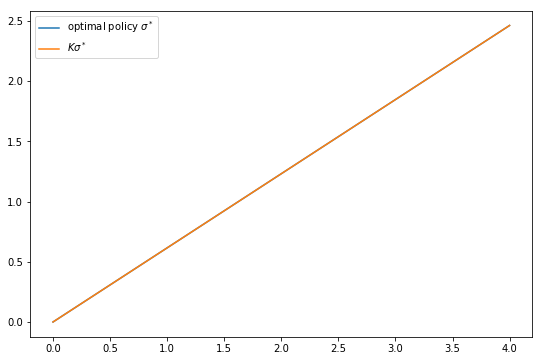

In [6]:
β, grid = og.β, og.grid

def c_star(y):
    "True optimal policy"
    return (1 - α * β) * y

K = egm_operator_factory(og)  # Return the operator K with endogenous grid

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(grid, c_star(grid), label="optimal policy $\sigma^*$")
ax.plot(grid, K(c_star)(grid), label="$K\sigma^*$")

ax.legend()
plt.show()

We can’t really distinguish the two plots

In fact it’s easy to see that the difference is essentially zero:

In [7]:
max(abs(K(c_star)(grid) - c_star(grid)))

9.881666666666672e-06

Next let’s try iterating from an arbitrary initial condition and see if we
converge towards $ \sigma^* $

Let’s start from the consumption policy that eats the whole pie: $ \sigma(y) = y $

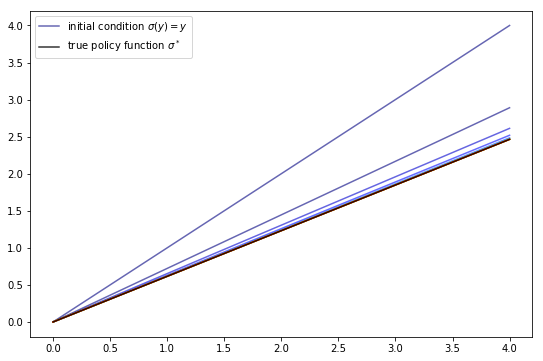

In [8]:
σ = lambda x: x
n = 15
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(grid, σ(grid), color=plt.cm.jet(0),
        alpha=0.6, label='initial condition $\sigma(y) = y$')

for i in range(n):
    σ = K(σ)  # Update policy
    ax.plot(grid, σ(grid), color=plt.cm.jet(i / n),  alpha=0.6)

ax.plot(grid, c_star(grid), 'k-',
        alpha=0.8, label='true policy function $\sigma^*$')

ax.legend()
plt.show()

We see that the policy has converged nicely, in only a few steps

## Speed

Now let’s compare the clock times per iteration for the standard Coleman-Reffett
operator (with exogenous grid) and the EGM version

We’ll do so using the CRRA model adopted in the exercises of the [Euler equation time iteration lecture](https://lectures.quantecon.org/py/coleman_policy_iter.html)

In [9]:
γ = 1.5   # Preference parameter

@njit
def u(c):
    return (c**(1 - γ) - 1) / (1 - γ)

@njit
def u_prime(c):
    return c**(-γ)

@njit
def u_prime_inv(c):
    return c**(-1 / γ)

og = OptimalGrowthModel(f=f,
                        f_prime=f_prime,
                        u=u,
                        u_prime=u_prime,
                        u_prime_inv=u_prime_inv)

K_time = time_operator_factory(og)     # Standard Coleman-Reffett operator
K_time(grid)                           # Call once to compile jitted version
K_egm = egm_operator_factory(og)       # Coleman-Reffett operator with endogenous grid

Here’s the result

In [10]:
sim_length = 20

print("Timing standard Coleman policy function iteration")
σ = grid    # Initial policy
qe.util.tic()
for i in range(sim_length):
    σ_new = K_time(σ)
    σ = σ_new
qe.util.toc()

print("Timing policy function iteration with endogenous grid")
σ = lambda x: x  # Initial policy
qe.util.tic()
for i in range(sim_length):
    σ_new = K_egm(σ)
    σ = σ_new
qe.util.toc()

Timing standard Coleman policy function iteration


TOC: Elapsed: 0:00:0.27
Timing policy function iteration with endogenous grid


TOC: Elapsed: 0:00:0.23


0.23141169548034668

We see that the EGM version is significantly faster, even without jit compilation!

The absence of numerical root finding means that it is typically more accurate at each step as well